In [1]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import pandas as pd
from IPython.display import HTML
from collections import deque
import importlib

%load_ext autoreload
%autoreload 2

import seaborn as sns
sns.set()
#sns.set(style="whitegrid")

import simulation
import controller
from simulation import *
from main_bus import MainBus
from genetic_main_bus import GeneticMainBus
from dqn_main_bus import DQNMainBus

Using TensorFlow backend.


### Genetic Algorithm

In [2]:
def crossover(par1, par2):
    
    dim_size = len(par1)

    sel = np.random.choice(dim_size, np.random.randint(dim_size), replace = False)

    ch1 = np.zeros(dim_size)
    ch2 = np.zeros(dim_size)

    for ix in range(dim_size):
        if ix in sel:
            ch1[ix] = 0.5*(par1[ix] + par2[ix])
            ch2[ix] = par1[ix]

        else:
            ch1[ix] = par2[ix]
            ch2[ix] = 0.5*(par1[ix] + par2[ix])
    
    ch1[0] = min(3, max(1, int(ch1[0])))
    ch2[0] = min(3, max(1, int(ch1[0])))
                 
    return ch1, ch2


def mutate(par1):
    mut = par1 + np.random.normal(0, 1, par1.shape)
    mut[0,0] = min(3, max(1, int(mut[0,0])))
    return mut[0]


def create_new_population(genomes, fitness, par_pct, child_pct, mut_pct):
    
    # Size of the population
    N = len(genomes)
    
    # Apply softmax probability calculation
    prob_distro =  fitness/ np.sum(fitness)
        
    # Allocate places in the population according to the given probabilities
    num_par = int(np.floor(N * par_pct))
    num_child = int(np.floor(N * child_pct / 2))
    num_mut = int(N - num_par - num_child * 2)
    
    new_pop = []
    
    # Add best parents
    best_par = np.random.choice(N, num_par, replace = False, p = prob_distro)
    for ix in best_par:
        #print(fitness[ix])
        new_pop.append(genomes[ix])
        
    # Match parents and add children
    for ix in range(num_child):
        idx = np.random.choice(N, 2, replace = False, p = prob_distro)
        (ch1, ch2) = crossover(genomes[idx[0]], genomes[idx[1]])
        new_pop.append(ch1)
        new_pop.append(ch2)
        
    # Add mutants
    for ix in range(num_mut):
        par1_idx = np.random.choice(N, 1)
        new_pop.append(mutate(genomes[par1_idx]))
        
    return new_pop, np.ones(N)/N

### Initialization

In [3]:
whole_day = 1440

# Parameters

replay_length = 100000
iterations = 144 # num of ticks before training
epochs = 2000 # num of times network is unfrozen, trained
batch_size = 32 # num of samples from replay memory to train on
animate = False
add_arrivals_noise = False

# Model
loggers = []#StateLogger(bus_id=24, save_every=1)]
simulation = Simulation(GeneticMainBus, loggers=loggers)
replay_memory = deque(maxlen = replay_length)
training_results = []
training_loss = []
delivered_passeners = []

save_every = 10

Initializing Prob Dist


In [6]:
# Initial iteration
simulation.reset(bus_genomes = [[1, 0, 0, 1, 1, 0.01], [2, 1, 1, 0, 1, 0.05], [3, 1, 1.5, 0, 1, 0.1]], genome_distro= [0.3, 0.5, 0.2])
simulation.execute(iterations=1440, animate=False, interval=50)

# Display results
num_del = simulation.controller.num_passengers_delivered
expenses = np.sum([bus.get_total_cost() for bus in simulation.controller.buses.values() ])
cost_ratio = expenses/num_del

num_messages = np.sum([bus.num_sent_messages for bus in simulation.controller.buses.values() ])

awt = (simulation.controller.total_waiting_time ) / (simulation.controller.num_passengers_delivered + simulation.controller.actual_passenger_count)

#+ simulation.controller.actual_passenger_count * 180

print('\n\tDelivered: {}'.format(num_del))
print('\tExpenses: {}'.format(expenses))
print('\tExpenses/Pass Del: {}'.format(cost_ratio))
print('\tMessages: {}'.format(num_messages))
print('\tAWT: {}'.format(awt))

bus_fitness = np.array([bus.cum_reward / MainBus._bus_type_travel_cost[bus.bus_type] for bus in simulation.controller.buses.values() ])
bus_genomes = np.array([bus.genome for bus in simulation.controller.buses.values() ])
init_genomes = np.array([bus.genome for bus in simulation.controller.buses.values() ])

print(len(bus_fitness))

 1440 / 1440 
	Delivered: 42238
	Expenses: 642918.0
	Expenses/Pass Del: 15.221317297220512
	Messages: 23724
	AWT: 79.8583342674588
50


In [9]:
best_perf = awt
best_fitness = bus_fitness
best_genomes = bus_genomes
    
# Evolution
for _ in range(10):
    
    # Evolution step
    (new_genomes, new_distro) = create_new_population(bus_genomes, bus_fitness, 0.4, 0.5, 0.1)
    
    # Evaluation
    simulation.reset(bus_genomes = new_genomes, genome_distro= new_distro)
    
    print(simulation.controller.waiting_cost)
    
    simulation.execute(iterations=1440, animate=False, interval=50)
    
    #/ bus.get_total_cost()
    
    # Get population stats
    #bus_fitness = np.array([bus.cum_reward for bus in simulation.controller.buses.values() ])
    bus_fitness = np.array([bus.cum_reward / MainBus._bus_type_travel_cost[bus.bus_type] for bus in simulation.controller.buses.values() ])
    bus_genomes = np.array([bus.genome for bus in simulation.controller.buses.values() ])

    # Display results
    num_del = simulation.controller.num_passengers_delivered
    expenses = np.sum([bus.get_total_cost() for bus in simulation.controller.buses.values() ])
    cost_ratio = expenses/num_del
    
    num_messages = np.sum([bus.num_sent_messages for bus in simulation.controller.buses.values() ])
    
    awt = (simulation.controller.waiting_cost + simulation.controller.actual_passenger_count * 180) / (simulation.controller.num_passengers_delivered + simulation.controller.actual_passenger_count)

    print('\n\tDelivered: {}'.format(num_del))
    print('\tExpenses: {}'.format(expenses))
    print('\tExpenses/Pass Del: {}'.format(cost_ratio))
    print('\tMessages: {}'.format(num_messages))
    print('\tAWT: {}'.format(awt))
    
    if awt < best_perf:
        best_perf = awt
        best_fitness = bus_fitness
        best_genomes = bus_genomes
    

0
 1440 / 1440 
	Delivered: 41964
	Expenses: 493170.0
	Expenses/Pass Del: 11.752216185301688
	Messages: 11430
	AWT: 35.64048873444681
0
 1440 / 1440 
	Delivered: 41897
	Expenses: 489075.0
	Expenses/Pass Del: 11.67327016254147
	Messages: 10193
	AWT: 36.16374845869297
0
 1440 / 1440 
	Delivered: 42061
	Expenses: 529964.0
	Expenses/Pass Del: 12.599890635030075
	Messages: 10337
	AWT: 35.04257370249972
0
 1440 / 1440 
	Delivered: 41980
	Expenses: 478483.5
	Expenses/Pass Del: 11.39789185326346
	Messages: 0
	AWT: 35.622665620446135
0
 1440 / 1440 
	Delivered: 41875
	Expenses: 508856.0
	Expenses/Pass Del: 12.151785074626865
	Messages: 0
	AWT: 36.43983858311849
0
 1440 / 1440 
	Delivered: 42168
	Expenses: 519505.0
	Expenses/Pass Del: 12.319887118193892
	Messages: 19516
	AWT: 34.480304898553975
0
 1440 / 1440 
	Delivered: 41858
	Expenses: 486626.0
	Expenses/Pass Del: 11.62563906541163
	Messages: 0
	AWT: 36.465059970855286
0
 1440 / 1440 
	Delivered: 40553
	Expenses: 383598.0
	Expenses/Pass Del: 

33.980921421365316


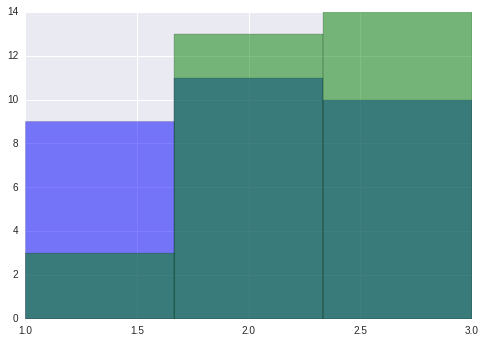

In [18]:
print(best_perf)
plt.hist(init_genomes[:,0], bins=3, alpha = 0.5, color = 'b')
plt.hist(best_genomes[:,0], bins=3, alpha = 0.5, color = 'g')
plt.show()


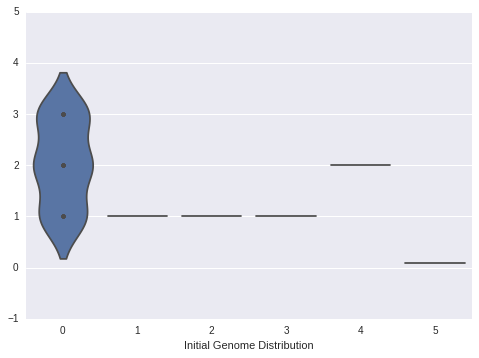

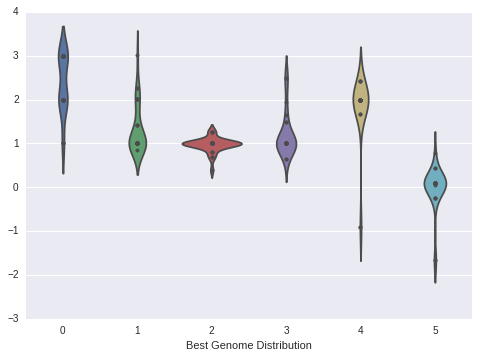

In [19]:
sns.violinplot(data=init_genomes, inner="points")
sns.despine(left=True, bottom=True)
plt.xlabel('Initial Genome Distribution')
plt.show()

sns.violinplot(data=best_genomes, inner="points")
sns.despine(left=True, bottom=True)
plt.xlabel('Best Genome Distribution')
plt.show()

In [ ]:
simulation.reset()
simulation.execute(iterations=1440, animate=False, interval=50)
print('\n\tdelivered:{}'.format(simulation.controller.num_passengers_delivered))

In [ ]:
print('Buses: ',len(simulation.controller.buses.values()))
for bus in simulation.controller.buses.values():
    print(bus.bus_id -23, bus.genome, bus.cum_reward)

In [6]:
HTML(simulation.anim.to_html5_video())

1439

In [ ]:
print('\r\tdelivered:{}'.format(simulation.controller.num_passengers_delivered))

In [ ]:
choice = 5


state = simulation.controller.logged_data['Bus 24 State Logger'][choice].T
s = np.zeros((24,1))
titles = ['current station','expected capacity**','destination decomposition','waiting time at stations','passenger similarity']
for i in range(5):
    if i>0:
        s += state[i*24:(i+1)*24] * (0 if i==4 else 1)
        #print(i)
        #print(state[i*24:(i+1)*24])
    
    if i != 4:
        plt.title(titles[i])
        #plt.bar(range(24), s)
        plt.bar(range(24), state[i*24:(i+1)*24])
        plt.xticks(np.array(range(24))+0.4,range(24))
        plt.show()
        
plt.title(titles[i])
plt.bar(range(24), s, color='g')
plt.xticks(np.array(range(24))+0.4,range(24))
plt.show()
    


In [ ]:
for i in range(10):
    print(np.random.choice(range(2), p=[0.1, 0.9] ))

In [ ]:
19.5/20

In [ ]:
gli 